In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageChops, ImageEnhance

In [19]:


def error_level_analysis(image, quality=90):
    """Perform Error Level Analysis (ELA) on an image."""
    try:
        im = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        temp_compressed = "temp_compressed.jpg"
        im.save(temp_compressed, "JPEG", quality=quality)
        compressed = Image.open(temp_compressed)
        ela_image = ImageChops.difference(im, compressed)
        ela_image = ImageEnhance.Brightness(ela_image).enhance(5)
        os.remove(temp_compressed)
        return cv2.cvtColor(np.array(ela_image), cv2.COLOR_RGB2BGR)
    except Exception as e:
        print(f"ELA Error: {e}")
        return None

def preprocess_image(image, image_size=(128, 128)):
    ela_image = error_level_analysis(image)
    if ela_image is None:
        return None
    ela_resized = cv2.resize(ela_image, image_size)
    gray = cv2.cvtColor(ela_resized, cv2.COLOR_BGR2GRAY)
    return gray.reshape(image_size[0], image_size[1], 1)


In [20]:
def prepare_dataset(dataset_path, image_size=(128, 128), data_limit=None):
    """Load and preprocess images, returning feature matrix X and labels y."""
    X, y = [], []
    for class_name in ["Au", "Tp"]:
        class_path = os.path.join(dataset_path, class_name)
        label = 0 if class_name == "Au" else 1
        data_list = (
            os.listdir(class_path)[0:data_limit]
            if data_limit
            else os.listdir(class_path)
        )
        for img_file in data_list:
            if img_file.lower().endswith(
                (".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp")
            ):
                img = cv2.imread(os.path.join(class_path, img_file))
                processed_img = preprocess_image(img, image_size)
                if processed_img is not None:
                    X.append(processed_img)
                    y.append(label)
    return np.array(X), np.array(y)

In [21]:


# Define the CNN model
def build_model(input_shape=(128, 128, 1), num_classes=2):
    model = models.Sequential()

    # First convolutional layer: 32 filters, 5x5 kernel
    model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=input_shape))

    # Second convolutional layer: 32 filters, 5x5 kernel
    model.add(layers.Conv2D(32, (5, 5), activation='relu'))

    # Max pooling layer with 2x2 pool size
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Dropout to prevent overfitting
    model.add(layers.Dropout(0.25))

    # Flatten layer to convert 2D feature maps to 1D feature vector
    model.add(layers.Flatten())

    # Fully connected (dense) layer
    model.add(layers.Dense(128, activation='relu'))

    # Output layer with softmax activation
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile model with RMSprop optimizer
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model



In [28]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

def train_model(model, X, y, epochs=12):
    """Train the model with optimized parameters and class weighting."""

    # One-hot encode the labels
    y = to_categorical(y, num_classes=2)

    # Train/val/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y.argmax(axis=1), random_state=42
    )
    print(X_train.shape, y_train.shape)

    X_test, X_val, y_test, y_val = train_test_split(
        X_test, y_test, test_size=0.5, stratify=y_test.argmax(axis=1), random_state=42
    )
    print(X_test.shape, y_test.shape)
    print(X_val.shape, y_val.shape)

    # Normalize pixel values
    X_train = X_train.astype("float32") / 255.0
    X_val = X_val.astype("float32") / 255.0
    X_test = X_test.astype("float32") / 255.0

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
    )
    return model, history, X_test, y_test


In [34]:
def evaluate_model(model, X_test, y_test):
    """Evaluate the model on the test set and generate various plots."""
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    print("\nTest Metrics:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Non-Forged", "Forged"],
        yticklabels=["Non-Forged", "Forged"],
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {test_auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(recall, precision, label="Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

In [30]:
model = build_model()
model.summary()

/Users/logpoint/Documents/SoftwareProjects/Thesis/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 124, 124, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 120, 120, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,772,450 (56.35 MB)

 Trainable params: 14,772,450 (56.35 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
image_size = (128, 128)
# Step 2: Define dataset path and image size
dataset_path = r"./CASIA22"

# Step 3: Prepare dataset
X, y = prepare_dataset(dataset_path, image_size)

In [32]:
model, history, X_test, y_test = train_model(model, X, y, epochs=12)


(10091, 128, 128, 1) (10091, 2)
(1261, 128, 128, 1) (1261, 2)
(1262, 128, 128, 1) (1262, 2)
Epoch 1/12
316/316 ━━━━━━━━━━━━━━━━━━━━ 308s 973ms/step - accuracy: 0.5903 - loss: 0.6402 - val_accuracy: 0.6181 - val_loss: 0.6017
Epoch 2/12
316/316 ━━━━━━━━━━━━━━━━━━━━ 312s 986ms/step - accuracy: 0.6801 - loss: 0.5841 - val_accuracy: 0.7274 - val_loss: 0.5536
Epoch 3/12
316/316 ━━━━━━━━━━━━━━━━━━━━ 309s 977ms/step - accuracy: 0.7534 - loss: 0.5135 - val_accuracy: 0.7456 - val_loss: 0.5459
Epoch 4/12
316/316 ━━━━━━━━━━━━━━━━━━━━ 307s 971ms/step - accuracy: 0.7883 - loss: 0.4624 - val_accuracy: 0.7956 - val_loss: 0.4631
Epoch 5/12
316/316 ━━━━━━━━━━━━━━━━━━━━ 305s 965ms/step - accuracy: 0.8251 - loss: 0.3848 - val_accuracy: 0.8082 - val_loss: 0.4478
Epoch 6/12
316/316 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - accuracy: 0.8668 - loss: 0.3144 - val_accuracy: 0.8154 - val_loss: 0.4668
Epoch 7/12
316/316 ━━━━━━━━━━━━━━━━━━━━ 313s 990ms/step - accuracy: 0.8950 - loss: 0.2423 - val_accuracy: 0.7647 - val_

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve
)
import numpy as np

def evaluate_model(model, X_test, y_test):
    """Evaluate the model on the test set and generate plots."""
    
    # Step 1: Evaluate and unpack loss and accuracy
    results = model.evaluate(X_test, y_test, verbose=1)
    test_loss = results[0]
    test_accuracy = results[1] if len(results) > 1 else None
    
    print("\n📊 Evaluation Results:")
    print(f"Loss:     {test_loss:.4f}")
    if test_accuracy is not None:
        print(f"Accuracy: {test_accuracy:.4f}")
    
    # Step 2: Predict
    y_pred_proba = model.predict(X_test)
    if y_pred_proba.shape[1] == 1:
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()
        y_test_labels = y_test.flatten()
        y_pred_scores = y_pred_proba.flatten()
    else:
        y_pred = np.argmax(y_pred_proba, axis=1)
        y_test_labels = np.argmax(y_test, axis=1)
        y_pred_scores = y_pred_proba[:, 1] if y_pred_proba.shape[1] > 1 else y_pred_proba[:, 0]

    # Step 3: Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test_labels, y_pred))

    # Step 4: Confusion Matrix
    cm = confusion_matrix(y_test_labels, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Non-Forged", "Forged"],
        yticklabels=["Non-Forged", "Forged"],
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Step 5: ROC Curve
    fpr, tpr, _ = roc_curve(y_test_labels, y_pred_scores)
    plt.figure()
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

    # Step 6: Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test_labels, y_pred_scores)
    plt.figure()
    plt.plot(recall, precision, label="Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid()
    plt.show()


40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 209ms/step - accuracy: 0.8133 - loss: 0.6773

📊 Evaluation Results:
Loss:     0.7248
Accuracy: 0.8144
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 205ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       749
           1       0.78      0.75      0.77       512

    accuracy                           0.81      1261
   macro avg       0.81      0.80      0.81      1261
weighted avg       0.81      0.81      0.81      1261



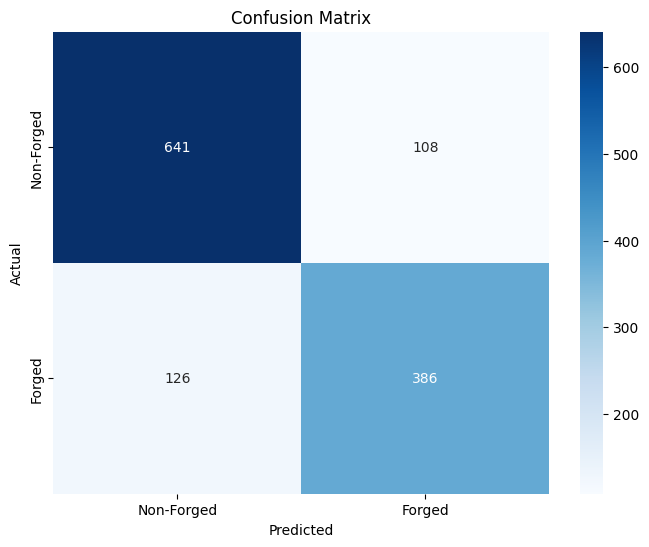

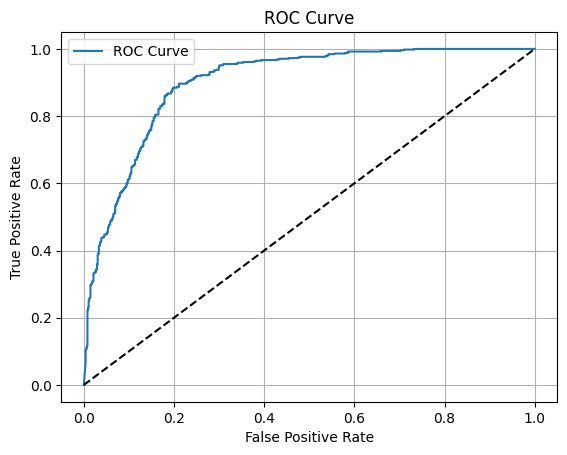

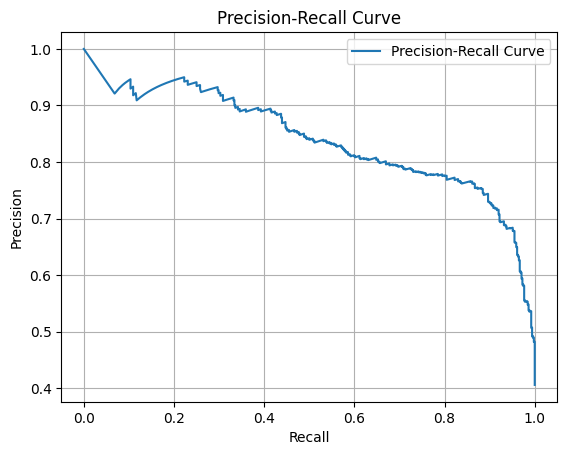

In [44]:
evaluate_model(model, X_test, y_test)

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


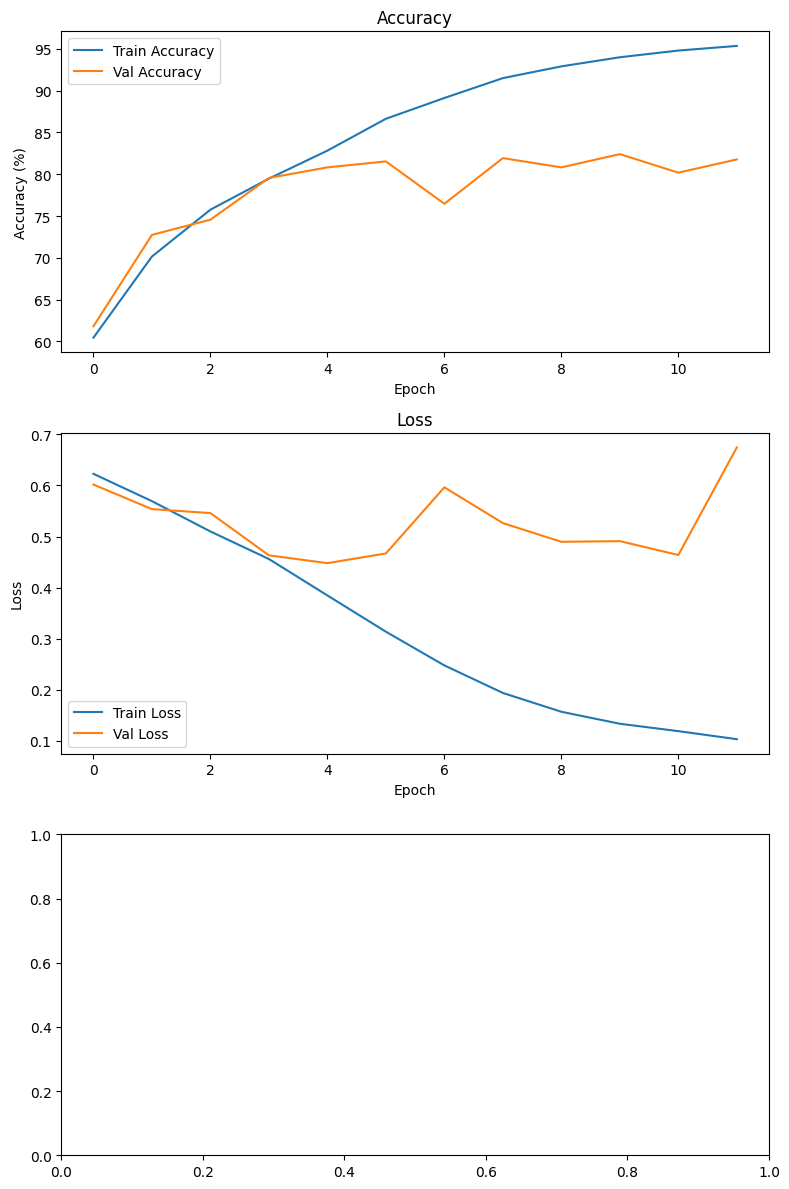

In [45]:
def plot_training_curves(history):
    """Plot training history including loss, accuracy, and AUC on a 0-100% scale."""
    print(history.history.keys())

    fig, ax = plt.subplots(3, 1, figsize=(8, 12))  # 3 rows, 1 column, taller figure

    # Accuracy (Scaled to 0-100%)
    ax[0].plot(np.array(history.history['accuracy']) * 100, label='Train Accuracy')
    ax[0].plot(np.array(history.history['val_accuracy']) * 100, label='Val Accuracy')
    ax[0].set_title('Accuracy')
    ax[0].set_ylabel('Accuracy (%)')
    ax[0].set_xlabel('Epoch')
    # ax[0].set_ylim(70, 110)
    ax[0].legend()

    # Loss (Keep original scale)
    ax[1].plot(np.array(history.history['loss']), label='Train Loss')
    ax[1].plot(np.array(history.history['val_loss']), label='Val Loss')
    ax[1].set_title('Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    # ax[1].set_ylim(0, 30)
    ax[1].legend()

    # AUC (Scaled to 0-100%)
    # ax[2].plot(np.array(history.history['auc']) * 100, label='Train AUC')
    # ax[2].plot(np.array(history.history['val_auc']) * 100, label='Val AUC')
    # ax[2].set_title('AUC Score')
    # ax[2].set_ylabel('AUC (%)')
    # ax[2].set_xlabel('Epoch')
    # # ax[2].set_ylim(80, 110)
    # ax[2].legend()

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()
# Step 6: Plot training curves
plot_training_curves(history)